## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import SpectralClustering
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [ ]:
BCW = pd.read_csv("../Data/wdbc.data", names = np.arange(1,33).tolist())
BCW = BCW.drop(1, axis = 1)

#  Monte-Carlo Simulation: Repeat the following procedures for supervised, un- supervised, and semi-supervised learning M = 30 times, and use randomly se- lected train and test data (make sure you use 20% of both the positve and nega- tive classes as the test set). Then compare the average scores (accuracy, precision, recall, F1-score, and AUC) that you obtain from each algorithm.

## Normalizing Data

In [ ]:
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(BCW.drop(2, axis = 1))
scaled_df = pd.DataFrame(d)
scaled_df['Target'] = BCW[2]
BCW = scaled_df

## Splitting Data (20% of both the positve and nega- tive classes as the test set)

In [ ]:
Malignant = BCW[BCW['Target'] == "M"]
Benign = BCW[BCW['Target'] == "B"]
# Here, we define a function that splits malignant and benign datapoints proportionately
def split(Malignant, Benign):
    X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(Malignant.drop('Target', axis = 1),
                                                        Malignant['Target'], test_size=0.2,shuffle = True)
    X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(Benign.drop('Target', axis = 1),
                                                        Benign['Target'], test_size=0.2,shuffle = True)
    X_train = X_train_m.append(X_train_b)
    X_test = X_test_m.append(X_test_b)
    y_train = y_train_m.append(y_train_b)
    y_test = y_test_m.append(y_test_b)
    return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = split(Malignant, Benign)
X = X_train.append(X_test)
y = y_train.append(y_test)

# Supervised Learning: Train an L1-penalized SVM to classify the data.

In [ ]:
svclassifier = svm.LinearSVC(penalty="l1", dual=False) #one vs rest
svclassifier.fit(X_train, y_train)

LinearSVC(dual=False, penalty='l1')

# 5 fold cross validation to choose the penalty parameter.

In [ ]:
C_range = np.logspace(-6, 50, 5)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
param_grid = dict(C = C_range)

### Running L1 penalized with best C over 30 iterations

In [ ]:
accuracies_test = []
precisions_test = []
recalls_test = []
f1s_test = []
aucs_test = []
accuracies_train = []
precisions_train = []
recalls_train = []
f1s_train = []
aucs_train = []
# We will need a label encoder to find the metrics
le = preprocessing.LabelEncoder()
le.fit(y)
for i in range (0, 30):
    X_train, y_train, X_test, y_test = split(Malignant, Benign)
    grid = GridSearchCV(svm.LinearSVC(penalty="l1", dual=False), param_grid=param_grid, cv=cv)
    grid.fit(X_train, y_train)
    svclassifier = svm.LinearSVC(penalty="l1", dual=False, C = grid.best_params_.get('C')) #one vs rest
    svclassifier.fit(X_train, y_train)
    y_pred_test = svclassifier.predict(X_test)
    accuracies_test.append(svclassifier.score(X_test, y_test))
    precisions_test.append(precision_score(y_test, y_pred_test, average='macro'))
    recalls_test.append(recall_score(y_test, y_pred_test, average='macro'))
    f1s_test.append(f1_score(y_test, y_pred_test, average='macro'))
    fpr, tpr, ths = roc_curve(le.transform(y_test), le.transform(y_pred_test))
    aucs_test.append(auc(fpr, tpr))

    y_pred_train = svclassifier.predict(X_train)
    accuracies_train.append(svclassifier.score(X_train, y_train))
    precisions_train.append(precision_score(y_train, y_pred_train, average='macro'))
    recalls_train.append(recall_score(y_train, y_pred_train, average='macro'))
    f1s_train.append(f1_score(y_train, y_pred_train, average='macro'))
    fpr, tpr, ths = roc_curve(le.transform(y_train), le.transform(y_pred_train))
    aucs_train.append(auc(fpr, tpr))

# Average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over M runs

In [ ]:
train_Accuracy = sum(accuracies_train)/len(accuracies_train)
train_precision = sum(precisions_train)/len(precisions_train)
train_recall = sum(recalls_train)/len(recalls_train)
train_f1 = sum(f1s_train)/len(f1s_train)
train_auc = sum(aucs_train)/len(aucs_train)
test_Accuracy = sum(accuracies_test)/len(accuracies_test)
test_precision = sum(precisions_test)/len(precisions_test)
test_recall = sum(recalls_test)/len(recalls_test)
test_f1 = sum(f1s_test)/len(f1s_test)
test_auc = sum(aucs_test)/len(aucs_test)
print("The following are the metrics for Training")
print("\nTrain Accuracy\t", train_Accuracy)
print("Train Precision\t", train_precision)
print("Train Recall\t", train_recall)
print("Train F1\t", train_f1)
print("Train AUC\t", train_auc)
print("\n\nThe following are the metrics for Testing")
print("\nTest Accuracy\t", test_Accuracy)
print("Test Precision\t", test_precision)
print("Test Recall\t", test_recall)
print("Test F1\t", test_f1)
print("Test AUC\t", test_auc)

The following are the metrics for Training

Train Accuracy	 0.9898678414096919
Train Precision	 0.990127381683882
Train Recall	 0.9881968234194957
Train F1	 0.9891388933181455
Train AUC	 0.9881968234194957


The following are the metrics for Testing

Test Accuracy	 0.9657971014492754
Test Precision	 0.9640092402527379
Test Recall	 0.9636304909560721
Test F1	 0.9634670151592405
Test AUC	 0.9636304909560721


# ROC and confusion matrix for training and testing in one of the runs.

Area under the Receiver Operating Characteristic curve: 0.9864112945084604


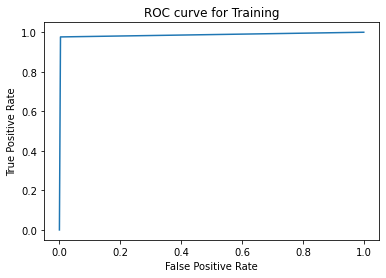

In [ ]:
fpr, tpr, ths = roc_curve(le.transform(y_train), le.transform(y_pred_train))
plt.plot(fpr, tpr)
plt.title('ROC curve for Training')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('Area under the Receiver Operating Characteristic curve:',
      auc(fpr, tpr))

Area under the Receiver Operating Characteristic curve: 0.974483204134367


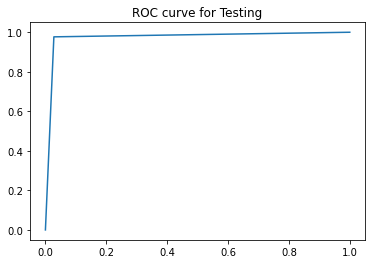

In [ ]:
fpr, tpr, ths = roc_curve(le.transform(y_test), le.transform(y_pred_test))
plt.plot(fpr, tpr)
plt.title('ROC curve for Testing')
print('Area under the Receiver Operating Characteristic curve:',
      auc(fpr, tpr))

In [ ]:
print('Confusion matrix for Training data\n', confusion_matrix(le.transform(y_train), le.transform(y_pred_train)))
print('\n\nConfusion matrix for Training data\n', confusion_matrix(le.transform(y_test), le.transform(y_pred_test)))

Confusion matrix for Training data
 [[284   1]
 [  4 165]]


Confusion matrix for Training data
 [[70  2]
 [ 1 42]]


# ii. Semi-Supervised Learning/ Self-training: Select 50% of the positive class along with 50% of the negative class in the training set as labeled data and the rest as unlabelled data.

In [ ]:
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(Malignant.drop('Target', axis = 1),
                                                        Malignant['Target'], test_size=0.2,shuffle = True)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(Benign.drop('Target', axis = 1),
                                                        Benign['Target'], test_size=0.2,shuffle = True)
LabelledX = X_train_m[0:int(X_train_m.shape[0]/2)].append(X_train_b[0:int(X_train_b.shape[0]/2)])
LabelledX = LabelledX.reset_index()
LabelledX = LabelledX.drop('index', axis = 1)
Labelledy = y_train_m[0:int(y_train_m.shape[0]/2)].append(y_train_b[0:int(y_train_b.shape[0]/2)])
Labelledy = Labelledy.tolist()
UnlabelledX = X_train_m[int(X_train_m.shape[0]/2):].append(X_train_b[int(X_train_b.shape[0]/2):])
UnlabelledX = UnlabelledX.reset_index()
UnlabelledX = UnlabelledX.drop('index', axis = 1)
Unlabelledy = y_train_m[int(y_train_m.shape[0]/2):].append(y_train_b[int(y_train_b.shape[0]/2):])
Unlabelledy = Unlabelledy.reset_index()
Unlabelledy = Unlabelledy.drop('index', axis = 1)

# A. Train an L1-penalized SVM to classify the labeled data. Use normalized data. Choose the penalty parameter using 5 fold cross validation.


In [ ]:
param_grid = dict(C = C_range)
grid = GridSearchCV(svm.LinearSVC(penalty="l1", dual=False), param_grid=param_grid, cv=cv)
grid.fit(LabelledX, Labelledy)
print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_))
# Setting initial model for 50% of Dataset
ovr = OneVsRestClassifier(svm.LinearSVC(penalty="l1", C = grid.best_params_.get('C'), dual=False)).fit(LabelledX, Labelledy)


The best parameters are {'C': 1e+50} with a score of 0.97


# B. Find the unlabeled data point that is the farthest to the decision boundary of the SVM. Let the SVM label it (ignore its true label), and add it to the labeled data, and retrain the SVM. Continue this process until all unlabeled data are used.

In [ ]:
while len(UnlabelledX) != 0:
    distance_to_decision_boundary = ovr.decision_function(UnlabelledX)
    len(distance_to_decision_boundary)
    #print('Farthest Datapoint from decision boundary is', np.argmax(distance_to_decision_boundary) ,'th datapoint')
    LabelledX = LabelledX.append(UnlabelledX.iloc[np.argmax(distance_to_decision_boundary)])
    #Labelledy = Labelledy.tolist()
    Labelledy.append(Unlabelledy.iloc[np.argmax(distance_to_decision_boundary)][0])
    UnlabelledX = UnlabelledX.drop(np.argmax(distance_to_decision_boundary))
    Unlabelledy = Unlabelledy.drop(np.argmax(distance_to_decision_boundary))
    LabelledX = LabelledX.reset_index()
    LabelledX = LabelledX.drop('index', axis = 1)
    #Labelledy = Labelledy.reset_index()
    #Labelledy = Labelledy.drop('index', axis = 1)
    UnlabelledX = UnlabelledX.reset_index()
    UnlabelledX = UnlabelledX.drop('index', axis = 1)
    Unlabelledy = Unlabelledy.reset_index()
    Unlabelledy = Unlabelledy.drop('index', axis = 1)
    grid.fit(LabelledX, Labelledy)
    ovr = OneVsRestClassifier(svm.LinearSVC(penalty="l1", C = grid.best_params_.get('C'), dual=False)).fit(LabelledX, Labelledy)
print('All Unlabelled data is now labelled')


All Unlabelled data is now labelled


# B.  Test the final SVM on the test data and the average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs.

In [ ]:
accuracies_test = []
precisions_test = []
recalls_test = []
f1s_test = []
aucs_test = []
accuracies_train = []
precisions_train = []
recalls_train = []
f1s_train = []
aucs_train = []
for i in range (0, 30):
    y_pred_test = ovr.predict(X_test)
    accuracies_test.append(ovr.score(X_test, y_test))
    precisions_test.append(precision_score(y_test, y_pred_test, average='macro'))
    recalls_test.append(recall_score(y_test, y_pred_test, average='macro'))
    f1s_test.append(f1_score(y_test, y_pred_test, average='macro'))
    fpr, tpr, ths = roc_curve(le.transform(y_test), le.transform(y_pred_test))
    aucs_test.append(auc(fpr, tpr))
    y_pred_train = ovr.predict(LabelledX)
    accuracies_train.append(ovr.score(LabelledX, Labelledy))
    precisions_train.append(precision_score(Labelledy, y_pred_train, average='macro'))
    recalls_train.append(recall_score(Labelledy, y_pred_train, average='macro'))
    f1s_train.append(f1_score(Labelledy, y_pred_train, average='macro'))
    fpr, tpr, ths = roc_curve(le.transform(Labelledy), le.transform(y_pred_train))
    aucs_train.append(auc(fpr, tpr))
test_Accuracy = sum(accuracies_test)/len(accuracies_test)
test_precision = sum(precisions_test)/len(precisions_test)
test_recall = sum(recalls_test)/len(recalls_test)
test_f1 = sum(f1s_test)/len(f1s_test)
test_auc = sum(aucs_test)/len(aucs_test)
train_Accuracy = sum(accuracies_train)/len(accuracies_train)
train_precision = sum(precisions_train)/len(precisions_train)
train_recall = sum(recalls_train)/len(recalls_train)
train_f1 = sum(f1s_train)/len(f1s_train)
train_auc = sum(aucs_train)/len(aucs_train)
print("The following are the metrics for Training")
print("\nTrain Accuracy\t", train_Accuracy)
print("Train Precision\t", train_precision)
print("Train Recall\t", train_recall)
print("Train F1\t", train_f1)
print("Train AUC\t", train_auc)
print("\n\nThe following are the metrics for Testing")
print("\nTest Accuracy\t", test_Accuracy)
print("Test Precision\t", test_precision)
print("Test Recall\t", test_recall)
print("Test F1\t", test_f1)
print("Test AUC\t", test_auc)

The following are the metrics for Training

Train Accuracy	 0.9911894273127756
Train Precision	 0.9917795071877151
Train Recall	 0.9893698743901175
Train F1	 0.9905511155511161
Train AUC	 0.9893698743901175


The following are the metrics for Testing

Test Accuracy	 1.0
Test Precision	 1.0
Test Recall	 1.0
Test F1	 1.0
Test AUC	 1.0


# B. Plot the ROC and report the confusion matrix for training and testing in one of the runs.

Area under the Receiver Operating Characteristic curve: 0.9893698743901174


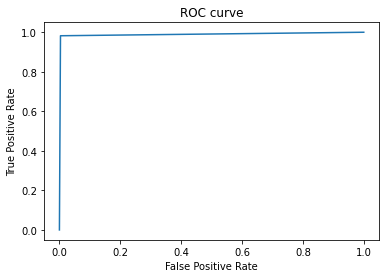

In [ ]:
fpr, tpr, ths = roc_curve(le.transform(Labelledy), le.transform(y_pred_train))
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('Area under the Receiver Operating Characteristic curve:',
      auc(fpr, tpr))

Area under the Receiver Operating Characteristic curve: 1.0


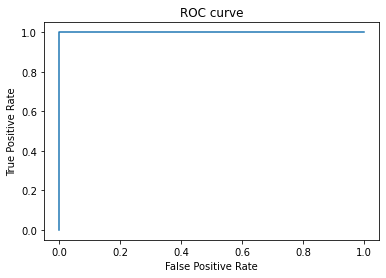

In [ ]:
fpr, tpr, ths = roc_curve(le.transform(y_test), le.transform(y_pred_test))
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('Area under the Receiver Operating Characteristic curve:',
      auc(fpr, tpr))

In [ ]:
print("Confusion Matrix for training\n", confusion_matrix(le.transform(Labelledy), le.transform(y_pred_train)))
print("\n\nConfusion Matrix for testing\n", confusion_matrix(le.transform(y_test), le.transform(y_pred_test)))

Confusion Matrix for training
 [[284   1]
 [  3 166]]


Confusion Matrix for testing
 [[72  0]
 [ 0 43]]


# iii. Unsupervised Learning: Run k-means algorithm on the whole training set. Ignore the labels of the data, and assume k = 2.

# A. Run the k-means algorithm multiple times. Make sure that you initialize the algoritm randomly. How do you make sure that the algorithm was not trapped in a local minimum?

### K means is prone to be stuck in a local minimum. To ensure that this doesnt happen, we must run it multiple times and randomize the initialization of centroids everytime. After this, we take the best model amidst these. This will ensure that the model error is at its actual. minimum

In [ ]:
sc = []
for i in range (0, 10):
    kmeans = KMeans(n_clusters=2, init = 'random')
    kmeans.fit(X_train)
    score = silhouette_score(X_train, kmeans.labels_)
    sc.append(score)

print('The best model as found by silhoutte coefficients is', np.argmax(sc))

The best model as found by silhoutte coefficients is 0


## B. Compute the centers of the two clusters and find the closest 30 data points to each center.

In [ ]:
print("The centers of the 2 clusters are at the following coordinates\n\n", kmeans.cluster_centers_)

The centers of the 2 clusters are at the following coordinates

 [[0.49205188 0.39530276 0.49202738 0.34934715 0.45841059 0.407964
  0.39922771 0.44669547 0.44921329 0.28955107 0.17742958 0.19320885
  0.16703335 0.11719975 0.17799384 0.25923153 0.12320286 0.30468268
  0.18895455 0.1340821  0.46417006 0.45278416 0.44988162 0.29745209
  0.48965334 0.36107771 0.38176149 0.63854767 0.33423807 0.25972975]
 [0.24835947 0.28747393 0.24030496 0.13887351 0.36397718 0.18246163
  0.10085114 0.1280146  0.34011253 0.26359173 0.06279925 0.1897248
  0.05782676 0.02758381 0.18555426 0.12995245 0.05664314 0.17896623
  0.17258558 0.08480775 0.20001922 0.3203902  0.18708484 0.09630769
  0.36468442 0.14875531 0.12914625 0.25998063 0.22452463 0.15797608]]


### This dataframe has the distance of each datapoint to the closest cluster center along with the predicted class and actual label

In [ ]:
X_dist = kmeans.transform(X_train)**2
mins = []
for i in range (0, len(X_dist)):
    mins.append(X_dist[i].min())
kdistances = pd.DataFrame(mins, columns=['Distance from closest Centroid'])
kdistances['Predicted cluster'] = kmeans.predict(X_train)
kdistances['True labels'] = y_train.tolist()
kdistances

,Distance from closest Centroid,Predicted cluster,True labels
0,0.410694,0,M
1,0.655222,0,M
2,0.311157,1,M
3,0.253408,0,M
4,0.138795,0,M
...,...,...,...
449,0.299943,1,B
450,0.322305,1,B
451,0.133306,1,B
452,0.124699,1,B


### The closest 30 points to each center are

In [ ]:
print('These are the 30 closest datapoints to the centroid in cluster 0\n')
print(kdistances[kdistances['Predicted cluster']== 0].sort_values(by=['Distance from closest Centroid'])[:30])
print('\n\nThese are the 30 closest datapoints to the centroid in cluster 1\n')
print(kdistances[kdistances['Predicted cluster']== 1].sort_values(by=['Distance from closest Centroid'])[:30])

These are the 30 closest datapoints to the centroid in cluster 0

     Distance from closest Centroid  Predicted cluster True labels
140                        0.086786                  0           M
11                         0.091817                  0           M
124                        0.092082                  0           M
151                        0.125336                  0           M
98                         0.127538                  0           M
58                         0.131340                  0           M
101                        0.134967                  0           M
113                        0.135392                  0           M
4                          0.138795                  0           M
137                        0.143131                  0           M
14                         0.150309                  0           M
7                          0.154239                  0           M
164                        0.154255                  0         

# B. Read the true labels of those 30 data points and take a majority poll within them. The majority poll becomes the label predicted by k-means for the members of each cluster.

## Clearly, cluster 0 has majority poll of Malignant and Cluster 1 has majority poll Benign.
## Hence, the labels are cluster 0 -> benign. Cluster 1-> malignant

# B. Then compare the labels provided by k-means with the true labels of the training data and report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs.

The following are the metrics for Training

Train Accuracy	 0.9273127753303965
Train Precision	 0.9293581139218723
Train Recall	 0.9144088030727706
Train F1	 0.9209288824383164
Train AUC	 0.9144088030727706
The confusuion matric for Training is
 [[275  10]
 [ 23 146]]

Area under the Receiver Operating Characteristic curve: 0.9144088030727706


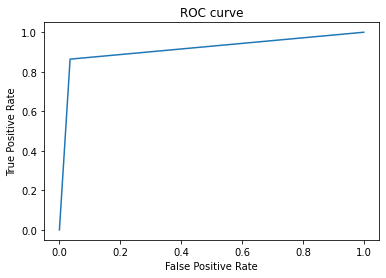

In [ ]:
y_pred = kmeans.predict(X_train)
train_Accuracy = accuracy_score(le.transform(y_train), y_pred)
precisions_train = precision_score(le.transform(y_train), y_pred, average='macro')
recalls_train = recall_score(le.transform(y_train), y_pred, average='macro')
f1s_train = f1_score(le.transform(y_train), y_pred, average='macro')
fpr, tpr, ths = roc_curve(le.transform(y_train), y_pred)
aucs_train = auc(fpr, tpr)
print("The following are the metrics for Training")
print("\nTrain Accuracy\t", train_Accuracy)
print("Train Precision\t", precisions_train)
print("Train Recall\t", recalls_train)
print("Train F1\t", f1s_train)
print("Train AUC\t", aucs_train)
fpr, tpr, ths = roc_curve(le.transform(y_train), y_pred)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print("The confusuion matric for Training is\n", confusion_matrix(le.transform(y_train), y_pred))
print('\nArea under the Receiver Operating Characteristic curve:',
      auc(fpr, tpr))

# C. Classify test data based on their proximity to the centers of the clusters. Report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs for the test data.

The following are the metrics for Testing

Test Accuracy	 0.9304347826086956
Test Precision	 0.9296308503625577
Test Recall	 0.9210271317829457
Test F1		 0.9249836921069797
Test AUC	 0.9210271317829458
The confusuion matric for Training is
 [[69  3]
 [ 5 38]]

Area under the Receiver Operating Characteristic curve: 0.9210271317829458


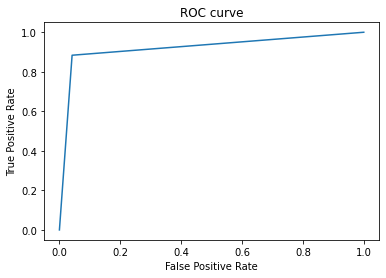

In [ ]:
y_pred = kmeans.predict(X_test)
test_Accuracy = accuracy_score(le.transform(y_test), y_pred)
precisions_test = precision_score(le.transform(y_test), y_pred, average='macro')
recalls_test = recall_score(le.transform(y_test), y_pred, average='macro')
f1s_test = f1_score(le.transform(y_test), y_pred, average='macro')
fpr, tpr, ths = roc_curve(le.transform(y_test), y_pred)
aucs_test = auc(fpr, tpr)
print("The following are the metrics for Testing")
print("\nTest Accuracy\t", test_Accuracy)
print("Test Precision\t", precisions_test)
print("Test Recall\t", recalls_test)
print("Test F1\t\t", f1s_test)
print("Test AUC\t", aucs_test)
fpr, tpr, ths = roc_curve(le.transform(y_test), y_pred)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print("The confusuion matric for Training is\n", confusion_matrix(le.transform(y_test), y_pred))
print('\nArea under the Receiver Operating Characteristic curve:',
      auc(fpr, tpr))


# iv. Spectral Clustering: Repeat 1(b)iii using spectral clustering, which is clus- tering based on kernels. Research what spectral clustering is.

## In practice Spectral Clustering is very useful when the structure of the individual clusters is highly non-convex, or more generally when a measure of the center and spread of the cluster is not a suitable description of the complete cluster, such as when clusters are nested circles on the 2D plane.

# iv. Use RBF kernel with gamma=1 or find a gamma for which the two clutsres have the same balance as the one in original data set (if the positive class has p and the negative class has n samples, the two clusters must have p and n members).

In [ ]:
clustering = SpectralClustering(n_clusters=2,assign_labels='discretize',
     random_state=0, affinity= 'rbf', gamma = 0.1).fit(X_train)
print('For this gamma, the 2 clusters have number of datapoints as follows', np.bincount(clustering.labels_))
print('which is close to the number of benign and malignant classes i training set-',len(X_train_b), len(X_train_m))

For this gamma, the 2 clusters have number of datapoints as follows [292 162]
which is close to the number of benign and malignant classes i training set- 285 169


# iv. Do not label data based on their proximity to cluster center, because spectral clustering may give you non-convex clusters . Instead, use fit − predict method.


## Reports for Training

The following are the metrics for training

train Accuracy	 0.9317180616740088
train Precision	 0.9304287163876205
train Recall	 0.9227343506695733
train F1		 0.9263091205160561
train AUC	 0.9227343506695734


The confusuion matric for training is
 [[273  12]
 [ 19 150]]


Area under the Receiver Operating Characteristic curve: 0.9227343506695734


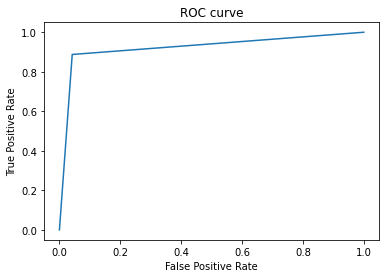

In [ ]:
y_pred = clustering.fit_predict(X_train)
train_Accuracy = accuracy_score(le.transform(y_train), y_pred)
precisions_train = precision_score(le.transform(y_train), y_pred, average='macro')
recalls_train = recall_score(le.transform(y_train), y_pred, average='macro')
f1s_train = f1_score(le.transform(y_train), y_pred, average='macro')
fpr, tpr, ths = roc_curve(le.transform(y_train), y_pred)
aucs_train = auc(fpr, tpr)
print("The following are the metrics for training")
print("\ntrain Accuracy\t", train_Accuracy)
print("train Precision\t", precisions_train)
print("train Recall\t", recalls_train)
print("train F1\t\t", f1s_train)
print("train AUC\t", aucs_train)

fpr, tpr, ths = roc_curve(le.transform(y_train), y_pred)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print("\n\nThe confusuion matric for training is\n", confusion_matrix(le.transform(y_train), y_pred))
print('\n\nArea under the Receiver Operating Characteristic curve:',
      auc(fpr, tpr))

## Reports for Testing

The following are the metrics for Testing

Test Accuracy	 0.9217391304347826
Test Precision	 0.9444444444444444
Test Recall	 0.8953488372093024
Test F1		 0.9121466768525592
Test AUC	 0.8953488372093024


The confusuion matric for Testing is
 [[72  0]
 [ 9 34]]


Area under the Receiver Operating Characteristic curve: 0.8953488372093024


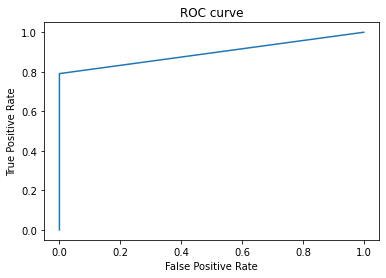

In [ ]:
y_pred = clustering.fit_predict(X_test)
test_Accuracy = accuracy_score(le.transform(y_test), y_pred)
precisions_test = precision_score(le.transform(y_test), y_pred, average='macro')
recalls_test = recall_score(le.transform(y_test), y_pred, average='macro')
f1s_test = f1_score(le.transform(y_test), y_pred, average='macro')
fpr, tpr, ths = roc_curve(le.transform(y_test), y_pred)
aucs_test = auc(fpr, tpr)
print("The following are the metrics for Testing")
print("\nTest Accuracy\t", test_Accuracy)
print("Test Precision\t", precisions_test)
print("Test Recall\t", recalls_test)
print("Test F1\t\t", f1s_test)
print("Test AUC\t", aucs_test)

fpr, tpr, ths = roc_curve(le.transform(y_test), y_pred)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print("\n\nThe confusuion matric for Testing is\n", confusion_matrix(le.transform(y_test), y_pred))
print('\n\nArea under the Receiver Operating Characteristic curve:',
      auc(fpr, tpr))


# v. One can expect that supervised learning on the full data set works better than semi-supervised learning with half of the data set labeled.One can expect that unsupervised learning underperforms in such situations. Compare the results you obtained by those methods.


### Following are the conclusive comparisons for each of the methods (Supervised SVM, Semi supervised SVM, Unsupervised Kmeans and Unsupervised Spectral Clustering)

### The Supervised and Semi Supervised method performed the best on train as well as test sets. Unsupervised methods are not at par with Supervised and Semi Supervised methods. Amidst Unsupervised methods, Kmeans clustering performs slightly better than Spectral Clustering